# Neighborhood Segmentation and Clustering in Ho Chi Minh City

## Description of the problem

### Exploring the neighborhood of Ho Chi Minh City, the biggest city in Vietnam

Collecting data of the geography as well as the density of HCM City in order to solve the problem of what is the most popular businesses in the main districts one, two and three

## Methodology

Collect data from Wikipedia about HCM City and the average housing price of each district.


Use FourSquare to find out what is the most popular business in the top districts: one, two and three

### Import necessary packages

In [1]:
pip install Unidecode # translate Vietnamese character 

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install folium #map rendering library

In [17]:
import pandas as pd
import numpy as np
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  


from bs4 import BeautifulSoup
import requests

import folium
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from unidecode import unidecode

### Importing Data from Wikipedia

In [6]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [7]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


### Finding the Average Housing Price

In [8]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [9]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [11]:

df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (1M VND)
0,1,410 /m2
1,2,82.8 /m2
2,3,264 /m2
3,4,91 /m2
4,5,253 /m2
5,6,106 /m2
6,7,88.5 /m2
7,8,67.2 /m2
8,9,44.9 /m2
9,10,217 /m2


In [12]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND)
0,1,10 wards,7.73,193632,25049.418,410 /m2
1,2,11 wards,49.74,147168,2958.745,82.8 /m2
2,3,14 wards,4.92,196333,39905.081,264 /m2
3,4,15 wards,4.18,186727,44671.531,91 /m2
4,5,15 wards,4.27,178615,41830.211,253 /m2
5,6,14 wards,7.19,258945,36014.604,106 /m2
6,7,10 wards,35.69,310178,8690.894,88.5 /m2
7,8,16 wards,19.18,431969,22521.846,67.2 /m2
8,9,13 wards,114,290620,2549.298,44.9 /m2
9,10,15 wards,5.72,238558,41705.944,217 /m2


#### Adding Latitude and Longtitude

In [13]:
def find_coor(name):
    address = name + " Ho Chi Minh City Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

In [14]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,410 /m2,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,82.8 /m2,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,264 /m2,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,91 /m2,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,253 /m2,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,106 /m2,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,88.5 /m2,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,67.2 /m2,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,44.9 /m2,10.667307,106.457661
9,10,15 wards,5.72,238558,41705.944,217 /m2,10.773198,106.667833


## HCM map

In [15]:
[hcm_lat, hcm_long] = find_coor("")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.7758439, 106.7017555.


In [16]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

Define Foursquare Credentials and Version

In [28]:
CLIENT_ID = 'NVZBQIKOTXW1WKLP0SDCUBBF2XATJIIJIOL2FQEIW11XVSUE'
CLIENT_SECRET = 'TW5AX5SDSK5GFWXSVBJE14J4RUUEXKPK1YOWWLBBDY5DH3X4'
VERSION = '20201206'

In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [31]:
hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
2,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store
3,1,10.77454,106.699184,Silverland Yen Hotel,10.774850,106.696160,Hotel
4,1,10.77454,106.699184,Annam Gourmet Saigon Centre,10.773204,106.700435,Supermarket


In [32]:
hcm_venues['Venue Category'].unique()[:50]

array(['Pizza Place', 'Hotel', 'Department Store', 'Supermarket',
       'Brewery', 'Spanish Restaurant', 'Multiplex', 'Jazz Club', 'Café',
       'Steakhouse', 'Vietnamese Restaurant', 'Speakeasy', 'Restaurant',
       'Massage Studio', 'Coffee Shop', 'Dessert Shop', 'Clothing Store',
       'Whisky Bar', 'Asian Restaurant', 'Italian Restaurant',
       'German Restaurant', 'Spa', 'Bar', 'Bookstore', 'Jewelry Store',
       'French Restaurant', 'Burger Joint', 'Opera House',
       'Vegetarian / Vegan Restaurant', 'Cupcake Shop',
       'Sushi Restaurant', 'Tapas Restaurant', 'Cocktail Bar',
       'North Indian Restaurant', 'Museum', 'Mexican Restaurant',
       'Thai Restaurant', 'Middle Eastern Restaurant', 'Beer Bar',
       'Hotel Bar', 'Indian Restaurant', 'Argentinian Restaurant',
       'Japanese Restaurant', 'Sandwich Place', 'Noodle House',
       'Hotpot Restaurant', 'Shoe Store', 'BBQ Joint',
       'Cajun / Creole Restaurant', 'Food Court'], dtype=object)

In [34]:
hcm_venues_group = hcm_venues.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,100,100,100,100,100,100
1,10,100,100,100,100,100,100
2,11,41,41,41,41,41,41
3,12,1,1,1,1,1,1
4,2,61,61,61,61,61,61
5,3,100,100,100,100,100,100
6,4,71,71,71,71,71,71
7,5,100,100,100,100,100,100
8,6,16,16,16,16,16,16
9,7,58,58,58,58,58,58


Number of venues in each districts

Text(0, 0.5, 'Number of venues')

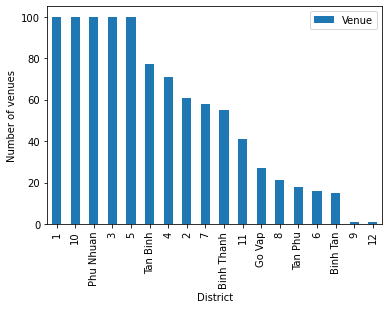

In [35]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

Number of venues in each category

In [36]:
most_venues = hcm_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Vietnamese Restaurant,135,135,135,135,135,135
Café,121,121,121,121,121,121
Coffee Shop,76,76,76,76,76,76
Seafood Restaurant,38,38,38,38,38,38
Hotel,28,28,28,28,28,28
Chinese Restaurant,23,23,23,23,23,23
Asian Restaurant,23,23,23,23,23,23
Vegetarian / Vegan Restaurant,22,22,22,22,22,22
Dessert Shop,19,19,19,19,19,19


Number of categories in each district 

Text(0, 0.5, 'Number of categories')

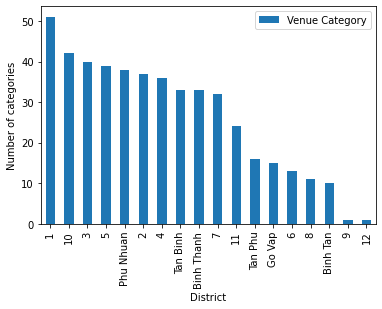

In [37]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

Top venue categories for each district

In [38]:
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,...,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wings Joint,Yoga Studio
0,1,0.00000,0.01,0.0,0.00,0.010000,0.000000,0.0,0.01000,0.000000,...,0.0,0.0,0.03000,0.110000,0.0,0.00000,0.01,0.0,0.000000,0.0
1,10,0.00000,0.00,0.0,0.01,0.020000,0.000000,0.0,0.01000,0.000000,...,0.0,0.0,0.02000,0.190000,0.0,0.00000,0.00,0.0,0.000000,0.0
2,11,0.02439,0.00,0.0,0.00,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.02439,0.097561,0.0,0.02439,0.00,0.0,0.000000,0.0
3,12,0.00000,0.00,0.0,0.00,0.000000,0.000000,0.0,0.00000,0.000000,...,0.0,0.0,0.00000,0.000000,0.0,0.00000,0.00,0.0,0.000000,0.0
4,2,0.00000,0.00,0.0,0.00,0.032787,0.016393,0.0,0.04918,0.016393,...,0.0,0.0,0.00000,0.131148,0.0,0.00000,0.00,0.0,0.016393,0.0


In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Pizza Place,Hotel Bar,Italian Restaurant,Japanese Restaurant,Vegetarian / Vegan Restaurant,Massage Studio
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Seafood Restaurant,Hotpot Restaurant,Bookstore,Hotel,Market,Snack Place
2,11,Café,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Cantonese Restaurant,American Restaurant,Breakfast Spot,Mobile Phone Shop,Dumpling Restaurant,Diner
3,12,Market,Yoga Studio,Food,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Food Truck
4,2,Vietnamese Restaurant,Restaurant,Café,Coffee Shop,Burger Joint,BBQ Joint,Bubble Tea Shop,Asian Restaurant,Seafood Restaurant,Bakery
5,3,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Hotel,Dessert Shop,Asian Restaurant,Pizza Place,Noodle House,Breakfast Spot
6,4,Vietnamese Restaurant,Seafood Restaurant,Café,Coffee Shop,Snack Place,Hotel,Chinese Restaurant,Food,Hostel,Japanese Restaurant
7,5,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Café,Dessert Shop,Asian Restaurant,Dim Sum Restaurant,Noodle House,Seafood Restaurant,BBQ Joint
8,6,Supermarket,Coffee Shop,Café,Breakfast Spot,Bookstore,Food Truck,Flea Market,Fast Food Restaurant,Bagel Shop,Pharmacy
9,7,Vietnamese Restaurant,Café,Seafood Restaurant,Coffee Shop,Gym / Fitness Center,Sushi Restaurant,Flea Market,Spa,Japanese Restaurant,Steakhouse


# Conclusion

The results show that Coffee and Restaurants are the most popular businesses in District 1,2  and 3